In [1]:
# quick config edit:
Configuration_Name = "Drillbotics"
Simulation_Name = "sim"
Initial_Bit_Depth = 2500

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib
import openlab

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%reload_ext autoreload

%store -r selected_features
%store -r target_col
%store -r input_timesteps
%store -r num_features
%store -r scaler_2
%store -r fit_columns
%store -r tags

model = load_model('my_model.h5')

In [3]:
username="ax.jorgensen@stud.uis.no"
apikey="EDE1872A07785D868992DEBB642A81C2DB726ECCA6E0DF115A44E43C6248AE8A"
licenseguid="c3a0315b-813c-4e0b-8ec9-e14436a1783d"

In [4]:
session = openlab.http_client(username=username, apikey=apikey, licenseguid=licenseguid)

Initializing http client...
Saving token...
Login Succesfull
Your openlab version 2.3.0 is outdated. Consider upgrading to 2.5.6


In [5]:
config_name = Configuration_Name
sim_name = Simulation_Name
initial_depth = Initial_Bit_Depth

In [6]:
sim = session.create_simulation(config_name,sim_name,initial_depth)

User limits: {'ActiveSimulationCount': 0, 'MaxConcurrentSimulations': 5, 'MaxSimulationCount': 0, 'MaxStepCount': 180000, 'MaxStoredSimulations': 10, 'MaxTimeStep': 18000, 'TotalSimulationCount': 1131, 'UsedCapacityPercent': 0, 'UsedStepCount': 709}
influx_type:  {}
No influx mode selected. Defaulting to 'no influx and loss'
Using non-transient model
Simulation Initialized


In [7]:
sim.setpoints.SurfaceRPM = 2 #HZ
sim.setpoints.TopOfStringVelocity = 0.02 #m/s
sim.setpoints.DesiredROP = 0.02 #m/s
sim.setpoints.FlowRateIn = 2500/60000 #converting l/min to m^3/s

1/1 [==============================] - 0s 276ms/step


<IPython.core.display.Javascript object>


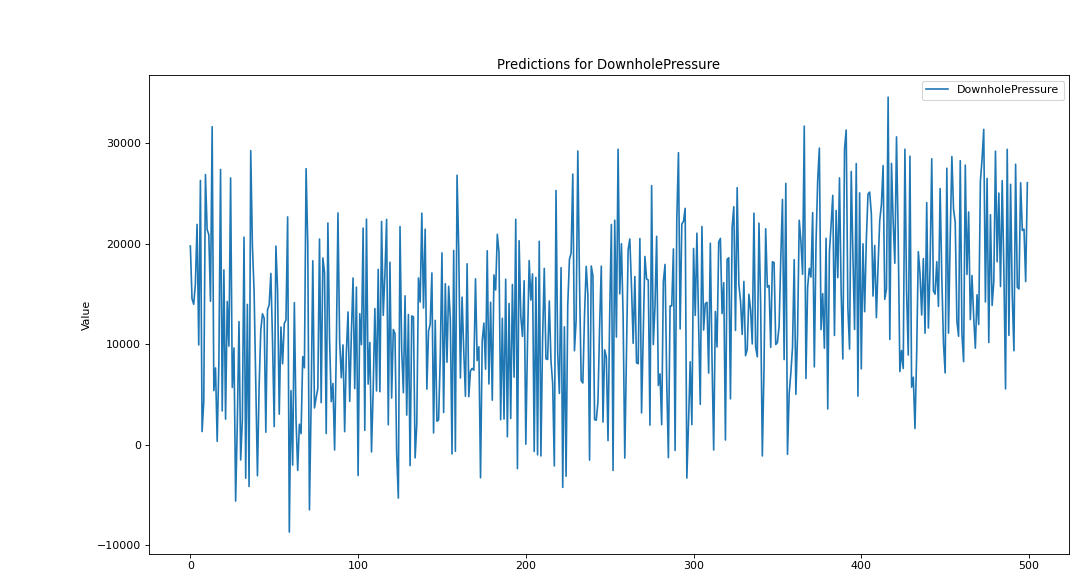

In [8]:
import matplotlib.pyplot as plt

timeStep = 1
endTime = 200

# Initialize the dataframes
unscaled_df = pd.DataFrame()
scaled_df = pd.DataFrame()
predictions_df = pd.DataFrame()  # Added this line to store predictions

# Loop through the time steps
while endTime > timeStep:
    # Step the simulation and retrieve results
    sim.step(timeStep)
    sim.get_results(timeStep, tags)

    # Extract the values of the selected features at this time step
    values = {}
    for feature in tags:
        # Skip "Connection" feature
        if feature == "Connection":
            continue
        # Create the variable name for the current feature
        var_name = f"{feature}"
        # Extract the value of the feature at this time step
        value_dict = eval(f"sim.results.{var_name}")
        value = list(value_dict.values())[0]  # Extract the value as a number
        # Add the value to the dictionary
        values[feature] = value
    values['timeStep'] = timeStep
    
    # Add the values to the unscaled dataframe
    unscaled_df = unscaled_df.append(values, ignore_index=True)
    
    # Check if there are input_timesteps worth of rows
    if unscaled_df.shape[0] >= input_timesteps:
        
        # Normalize the data using the saved scaler "scaler_2"
        scaled_data = scaler_2.transform(unscaled_df[fit_columns])
        
        # Reshape the data to fit the model
        input_data = scaled_data.reshape(1, input_timesteps, num_features)
        
        # Make a prediction
        prediction = model.predict(input_data)
        
        # Scale the prediction back to the original value
        unscaled_prediction = scaler_2.inverse_transform(prediction[0])

        # Append the unscaled prediction to the predictions dataframe
        predictions_df = predictions_df.append(pd.DataFrame(unscaled_prediction, columns=fit_columns), ignore_index=True)

        # Clear unscaled_df so it's ready to be filled up again
        unscaled_df = pd.DataFrame()
        
    timeStep += 1

# Plot the predictions dataframe
predictions_df.plot(figsize=(15, 8))
plt.title("Predictions")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend(fit_columns, loc="upper right")
plt.show()


In [21]:
# Plot the target_col of the predictions dataframe
predictions_df[target_col].plot(figsize=(15, 8))
plt.title(f"Predictions for {target_col}")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend([target_col], loc="upper right")
plt.show()